# PointNetDataLoader


In [ ]:
#!/usr/bin/env python
# PointNet for point cloud classification
#
# -- Paul CHECCHIN - 5/11/2021
#

import numpy as np
import random
import math
import os
import time
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Import functions to read and write ply files
from ply import write_ply, read_ply

class RandomRotation_z(object):
    """
    Applique une rotation aléatoire autour de l'axe Z à un nuage de points.
    """
    def __call__(self, pointcloud):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[math.cos(theta), -math.sin(theta),      0],
                               [math.sin(theta),  math.cos(theta),      0],
                               [0,                              0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    """
    Ajoute un bruit gaussien aléatoire à un nuage de points.
    """
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud

class ShufflePoints(object):
    """
    Mélange aléatoirement l'ordre des points dans un nuage de points.
    """
    def __call__(self, pointcloud):
        np.random.shuffle(pointcloud)
        return pointcloud

class RandomScaling(object):
    """
    Applique une mise à l'échelle aléatoire au nuage de points.
    """
    def __call__(self, pointcloud):
        scale = random.uniform(0.2, 2)
        scaled_pointcloud = pointcloud * scale
        return scaled_pointcloud

class ToTensor(object):
    """
    Convertit un nuage de points numpy en un tenseur PyTorch.
    """
    def __call__(self, pointcloud):
        return torch.from_numpy(pointcloud)

def default_transforms():
    """
    Définit une séquence de transformations par défaut pour le traitement des nuages de points.
    """
    return transforms.Compose([RandomRotation_z(),
                               RandomNoise(),
                               ShufflePoints(),
                               ToTensor()])

class PointCloudData(Dataset):
    """
    Charge un dataset de nuages de points à partir de fichiers .ply et applique des transformations.
    """
    def __init__(self,
                 root_dir,
                 folder="train",
                 transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))
                   if os.path.isdir(root_dir + "/" + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir+"/"+category+"/"+folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    sample = {}
                    sample['ply_path'] = new_dir+"/"+file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        """
        Retourne le nombre total d'échantillons dans le dataset.
        """
        return len(self.files)

    def __getitem__(self, idx):
        """
        Charge un échantillon donné par son index, applique les transformations et retourne un dictionnaire contenant le nuage de points transformé et sa catégorie.
        """
        ply_path = self.files[idx]['ply_path']
        category = self.files[idx]['category']
        data = read_ply(ply_path)
        pointcloud = self.transforms(np.vstack((data['x'],
                                                data['y'],
                                                data['z'])).T)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}


# Models

In [ ]:
class PointMLP(nn.Module):
    """
    MLP pour la classification de nuages de points.
    Prend un nuage de points aplati en entrée et applique des couches fully connected
    avec BatchNorm, ReLU, et dropout pour produire une classification.
    """
    def __init__(self, classes=40):
        super(PointMLP, self).__init__()

        self.fc1 = nn.Linear(3072, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

        self.fc3 = nn.Linear(256, classes)

        self.flatten = nn.Flatten()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.log_softmax(x)
        return x


class PointNetBasic(nn.Module):
    """
    Réseau de base PointNet pour la classification de nuages de points.
    Utilise des couches Conv1D pour extraire des features locaux, suivies de couches fully connected
    pour la classification. Inclut BatchNorm, ReLU, et dropout.
    """
    def __init__(self, classes=40):
        super().__init__()

        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(64)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.bn4 = nn.BatchNorm1d(128)

        self.conv5 = nn.Conv1d(128, 1024, kernel_size=1)
        self.bn5 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, classes)

        self.dropout = nn.Dropout(p=0.3)

        self.maxpool = nn.MaxPool1d(kernel_size=1024)

        self.log_softmax = nn.LogSoftmax(dim=1)

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        x = self.maxpool(x)
        x = self.flatten(x)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        x = self.log_softmax(x)
        return x


class Tnet(nn.Module):
    """
    Sous-réseau T-Net pour apprendre une transformation spatiale.
    Utilisé pour aligner les nuages de points dans un espace canonique.
    Produit une matrice de transformation 3x3.
    """
    def __init__(self, k=3):
        super().__init__()

        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, k*k)

        self.maxpool = nn.MaxPool1d(kernel_size=1024)

        self.flatten = nn.Flatten()

        self.k = k

        self.identity_matrix = torch.eye(3).view(-1)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = F.relu(self.bn3(self.conv3(output)))

        output = self.maxpool(output)
        output = self.flatten(output)

        output = F.relu(self.bn_fc1(self.fc1(output)))
        output = F.relu(self.bn_fc2(self.fc2(output)))
        output = self.fc3(output)

        k_matrix = output.view(-1, 3, 3)
        k_matrix += self.identity_matrix.view(1, 3, 3).to(device)

        return k_matrix


class PointNetFull(nn.Module):
    """
    Réseau PointNet complet pour la classification de nuages de points.
    Combine un T-Net pour l'alignement spatial et un PointNetBasic pour la classification.
    """
    def __init__(self, classes=40):
        super().__init__()

        self.Tnet = Tnet()
        self.pointNetBasic = PointNetBasic(classes)

        self.flatten = nn.Flatten()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        k_matrix = self.Tnet(input)
        output = torch.bmm(input.transpose(2,1), k_matrix).transpose(2,1)

        output = self.pointNetBasic(output)
        return output

# Loss functions

In [ ]:
def basic_loss(outputs, labels):
    """
    Perte de classification avec NLLLoss.
    """
    criterion = torch.nn.NLLLoss()
    return criterion(outputs, labels)


def pointnet_full_loss(outputs, labels, m3x3, alpha=0.001):
    """
    Perte de classification + régularisation sur la matrice de transformation.
    """
    criterion = torch.nn.NLLLoss()
    bsize = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bsize, 1, 1)
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)) / float(bsize)

# Train functions

In [ ]:
import torch
import matplotlib.pyplot as plt

def train_v1(model, device, train_loader, test_loader=None, epochs=250):
    """
    Entraîne le modèle  avec une perte de classification.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.transpose(1, 2))
            loss = basic_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        correct = total = 0
        val_loss = 0.0

        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs = model(inputs.transpose(1, 2))
                    loss = basic_loss(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100. * correct / total
            val_losses.append(val_loss / len(test_loader))
            val_accuracies.append(val_acc)

            print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.3f}, '
                  f'Test Loss: {val_losses[-1]:.3f}, Test Accuracy: {val_acc:.1f}%')

        scheduler.step()

    return train_losses, val_losses, val_accuracies


def train_v2(model, device, train_loader, test_loader=None, epochs=250):
    """
    Entraîne PointNetFull avec une perte combinée (classification + régularisation).
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3 = model(inputs.transpose(1, 2))
            loss = pointnet_full_loss(outputs, labels, m3x3)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        correct = total = 0
        val_loss = 0.0

        if test_loader:
            with torch.no_grad():
                for data in test_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __ = model(inputs.transpose(1, 2))
                    loss = pointnet_full_loss(outputs, labels, __)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100. * correct / total
            val_losses.append(val_loss / len(test_loader))
            val_accuracies.append(val_acc)

            print(f'Epoch: {epoch+1}, Train Loss: {train_losses[-1]:.3f}, '
                  f'Test Loss: {val_losses[-1]:.3f}, Test Accuracy: {val_acc:.1f}%')

        scheduler.step()

    return train_losses, val_losses, val_accuracies

# Train PointMLP

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  1716520
Device:  cpu
Epoch: 1, Train Loss: 3.485, Test Loss: 3.565, Test Accuracy: 6.2%
Epoch: 2, Train Loss: 3.421, Test Loss: 3.510, Test Accuracy: 6.9%
Epoch: 3, Train Loss: 3.370, Test Loss: 3.414, Test Accuracy: 8.9%
Epoch: 4, Train Loss: 3.302, Test Loss: 3.369, Test Ac

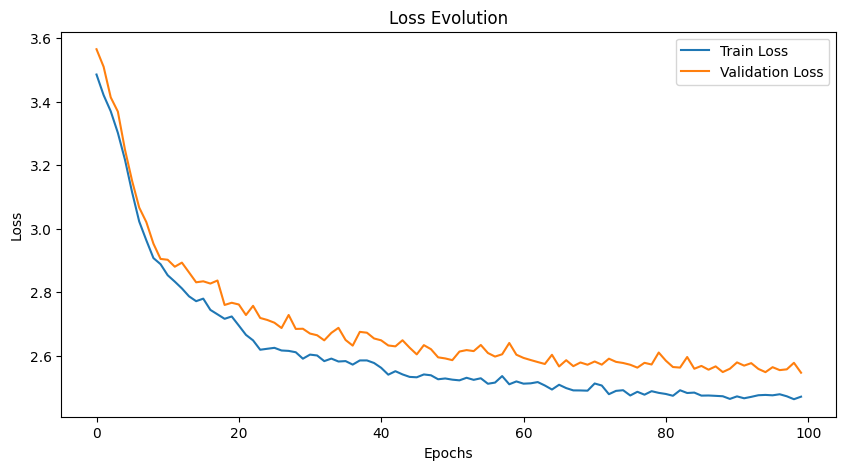

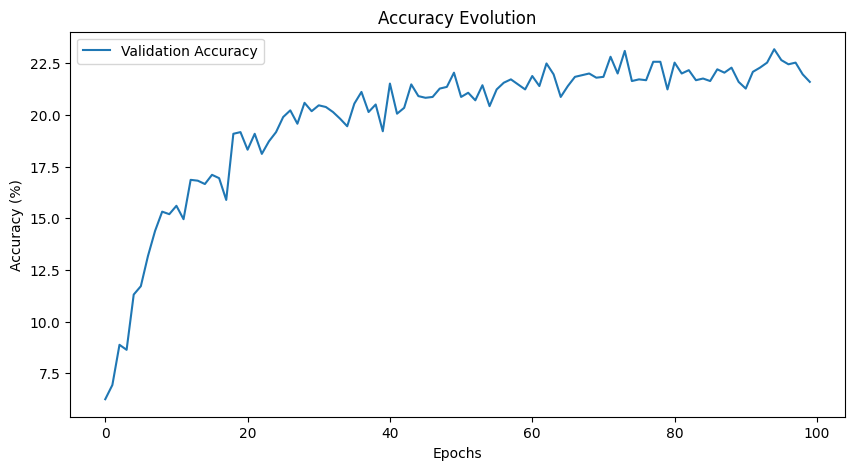

Total time for training :  2596.9085862636566


In [ ]:
t0 = time.time()

# Charge les datasets d'entraînement et de test
train_ds = PointCloudData("../data/ModelNet40_PLY")
test_ds = PointCloudData("../data/ModelNet40_PLY", folder='test')

# Affiche des informations sur les classes et les datasets
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

# Crée les DataLoader pour l'entraînement et le test
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

# Initialise le modèle PointMLP
model = PointMLP()

# Affiche le nombre de paramètres du modèle
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

# Configure le device (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model.to(device)

# Entraîne le modèle
train_losses, val_losses, val_accuracies = train_v1(model, device, train_loader, test_loader, epochs=100)

# Affiche les courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
if test_loader:
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.show()

# Affiche les courbes de précision
if test_loader:
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Evolution')
    plt.legend()
    plt.show()

# Affiche le temps total d'entraînement
print("Total time for training : ", time.time() - t0)

# Train PointNetBasic

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  819624
Device:  cpu
Epoch: 1, Train Loss: 1.607, Test Loss: 1.312, Test Accuracy: 64.1%
Epoch: 2, Train Loss: 0.976, Test Loss: 0.957, Test Accuracy: 71.2%
Epoch: 3, Train Loss: 0.854, Test Loss: 1.132, Test Accuracy: 64.8%
Epoch: 4, Train Loss: 0.789, Test Loss: 0.932, Test 

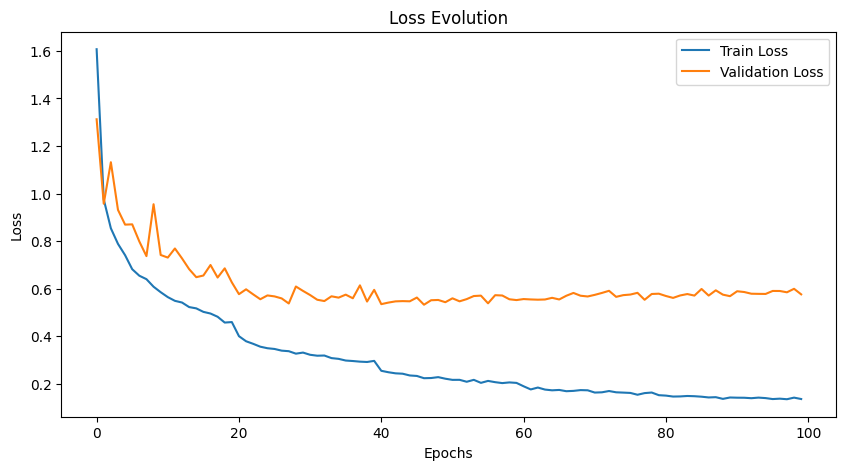

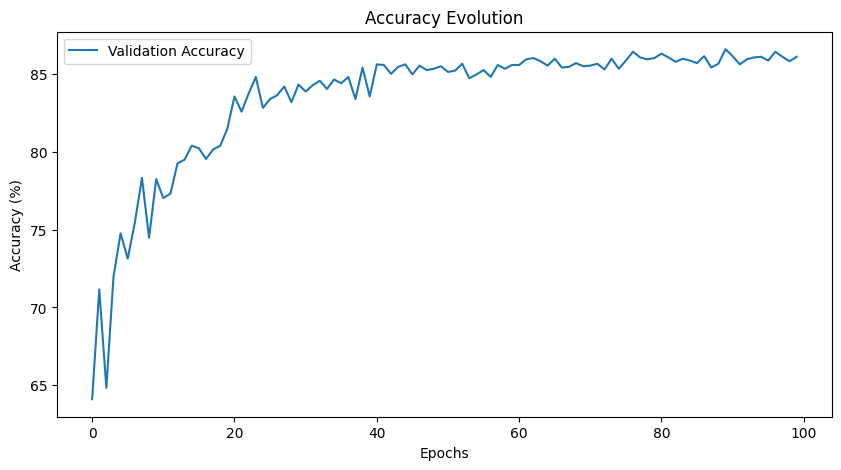

Total time for training :  29987.124975204468


In [ ]:
t0 = time.time()

# Charge les datasets d'entraînement et de test
train_ds = PointCloudData("../data/ModelNet40_PLY")
test_ds = PointCloudData("../data/ModelNet40_PLY", folder='test')

# Affiche des informations sur les classes et les datasets
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

# Crée les DataLoader pour l'entraînement et le test
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

# Initialise le modèle PointNetBasic
model = PointNetBasic()

# Affiche le nombre de paramètres du modèle
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

# Configure le device (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model.to(device)

# Entraîne le modèle
train_losses, val_losses, val_accuracies = train_v1(model, device, train_loader, test_loader, epochs=100)

# Affiche les courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
if test_loader:
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.show()

# Affiche les courbes de précision
if test_loader:
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Evolution')
    plt.legend()
    plt.show()

# Affiche le temps total d'entraînement
print("Total time for training : ", time.time() - t0)

# Train PointNetFull

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  1622705
Device:  cpu
Epoch: 1, Train Loss: 2.046, Test Loss: 2.089, Test Accuracy: 42.5%
Epoch: 2, Train Loss: 1.266, Test Loss: 1.340, Test Accuracy: 60.5%
Epoch: 3, Train Loss: 1.005, Test Loss: 1.248, Test Accuracy: 61.6%
Epoch: 4, Train Loss: 0.911, Test Loss: 0.974, Test

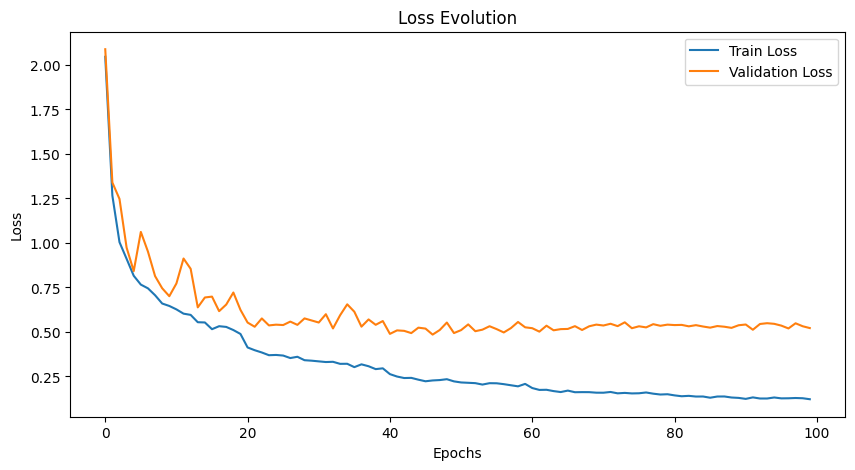

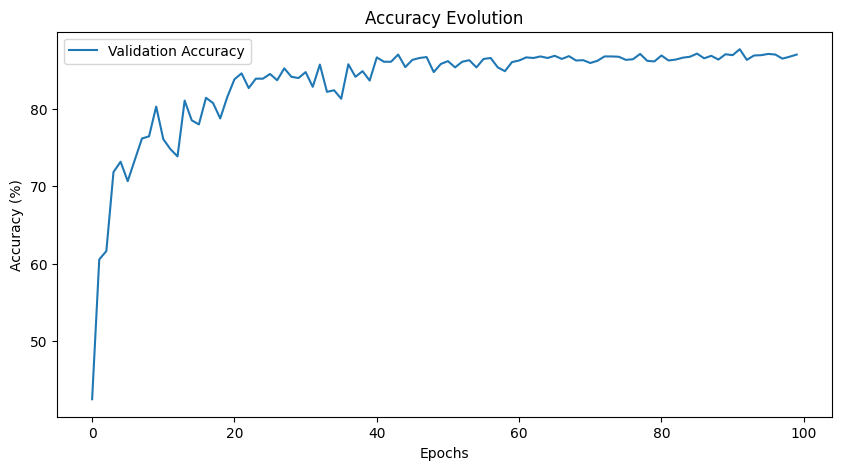

Total time for training :  58560.554414987564


In [ ]:
t0 = time.time()

# Charge les datasets d'entraînement et de test
train_ds = PointCloudData("../data/ModelNet40_PLY")
test_ds = PointCloudData("../data/ModelNet40_PLY", folder='test')

# Affiche des informations sur les classes et les datasets
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

# Crée les DataLoader pour l'entraînement et le test
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

# Initialise le modèle PointNetFull
model = PointNetFull()

# Affiche le nombre de paramètres du modèle
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

# Configure le device (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model.to(device)

# Entraîne le modèle avec la fonction train_v2
train_losses, val_losses, val_accuracies = train_v2(model, device, train_loader, test_loader, epochs=100)

# Affiche les courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
if test_loader:
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.show()

# Affiche les courbes de précision
if test_loader:
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Evolution')
    plt.legend()
    plt.show()

# Affiche le temps total d'entraînement
print("Total time for training : ", time.time() - t0)

# Train PointNetFull with custom data augmentation

Classes:  {0: 'airplane', 1: 'bathtub', 2: 'bed', 3: 'bench', 4: 'bookshelf', 5: 'bottle', 6: 'bowl', 7: 'car', 8: 'chair', 9: 'cone', 10: 'cup', 11: 'curtain', 12: 'desk', 13: 'door', 14: 'dresser', 15: 'flower_pot', 16: 'glass_box', 17: 'guitar', 18: 'keyboard', 19: 'lamp', 20: 'laptop', 21: 'mantel', 22: 'monitor', 23: 'night_stand', 24: 'person', 25: 'piano', 26: 'plant', 27: 'radio', 28: 'range_hood', 29: 'sink', 30: 'sofa', 31: 'stairs', 32: 'stool', 33: 'table', 34: 'tent', 35: 'toilet', 36: 'tv_stand', 37: 'vase', 38: 'wardrobe', 39: 'xbox'}
Train dataset size:  9843
Test dataset size:  2468
Number of classes:  40
Sample pointcloud shape:  torch.Size([1024, 3])
Number of parameters in the Neural Networks:  1622705
Device:  cpu
Epoch: 1, Train Loss: 2.242, Test Loss: 1.504, Test Accuracy: 55.6%
Epoch: 2, Train Loss: 1.158, Test Loss: 1.501, Test Accuracy: 56.8%
Epoch: 3, Train Loss: 0.952, Test Loss: 1.063, Test Accuracy: 67.5%
Epoch: 4, Train Loss: 0.870, Test Loss: 0.907, Test

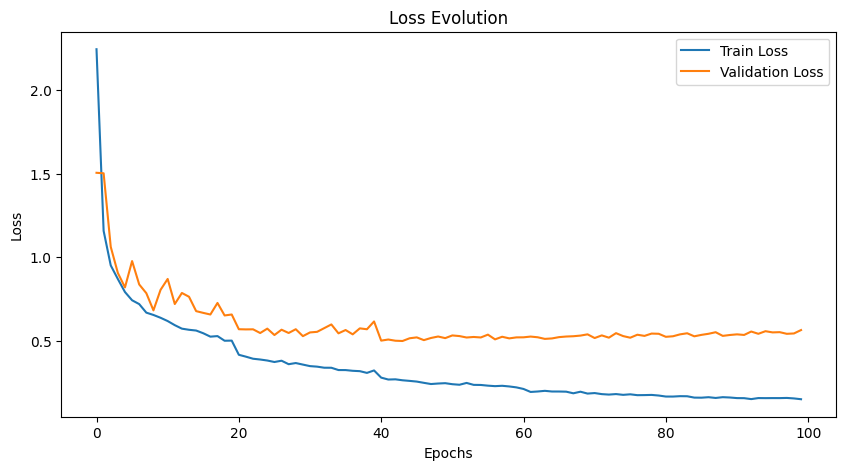

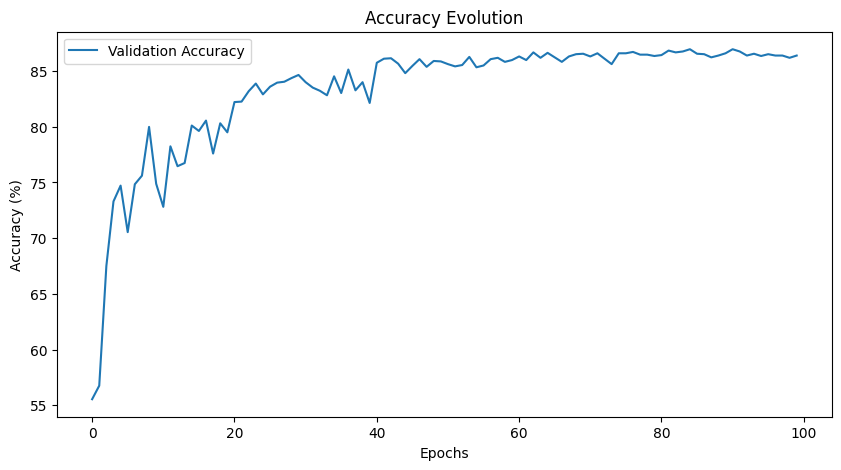

Total time for training :  58134.49354100227


In [ ]:
class RandomScaling(object):
    """
    Applique une mise à l'échelle aléatoire à un nuage de points.
    """
    def __call__(self, pointcloud):
        scale = random.uniform(0.2, 2)
        scaled_pointcloud = pointcloud * scale
        return scaled_pointcloud


def default_transforms():
    """
    Retourne une composition de transformations par défaut pour les nuages de points.
    """
    return transforms.Compose([RandomRotation_z(),
                               RandomNoise(),
                               ShufflePoints(),
                               RandomScaling(),
                               ToTensor()])


class PointCloudData(Dataset):
    """
    Dataset pour les nuages de points, charge les fichiers PLY et applique des transformations.
    """
    def __init__(self, root_dir, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir))
                   if os.path.isdir(root_dir + "/" + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir + "/" + category + "/" + folder
            for file in os.listdir(new_dir):
                if file.endswith('.ply'):
                    sample = {'ply_path': new_dir + "/" + file, 'category': category}
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ply_path = self.files[idx]['ply_path']
        category = self.files[idx]['category']
        data = read_ply(ply_path)
        pointcloud = self.transforms(np.vstack((data['x'], data['y'], data['z'])).T)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}


# Démarre le chronomètre
t0 = time.time()

# Charge les datasets d'entraînement et de test
train_ds = PointCloudData("../data/ModelNet40_PLY")
test_ds = PointCloudData("../data/ModelNet40_PLY", folder='test')

# Affiche des informations sur les classes et les datasets
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
print("Classes: ", inv_classes)
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

# Crée les DataLoader pour l'entraînement et le test
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=32)

# Initialise le modèle PointNetFull
model = PointNetFull()

# Affiche le nombre de paramètres du modèle
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of parameters in the Neural Networks: ", sum([np.prod(p.size()) for p in model_parameters]))

# Configure le device (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
model.to(device)

# Entraîne le modèle avec la fonction train_v2
train_losses, val_losses, val_accuracies = train_v2(model, device, train_loader, test_loader, epochs=100)

# Affiche les courbes de perte
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
if test_loader:
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.show()

# Affiche les courbes de précision
if test_loader:
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Evolution')
    plt.legend()
    plt.show()

# Affiche le temps total d'entraînement
print("Total time for training : ", time.time() - t0)